In [1]:
# libraries
from IPython.display import display, HTML
import pickle
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
import datetime

np.set_printoptions(precision=2, suppress=True, floatmode='fixed')

In [2]:
# problem definition
destinations = list('abcdefghijklmno'.upper())

with open('destination_coordinates.pkl', 'rb') as file:
    destination_coordinates = pickle.load(file)

with open('distances.pkl', 'rb') as file:
    distances = pickle.load(file)
    
distancesDF = pandas.DataFrame(data=distances, columns=destinations, index=destinations)

In [3]:
# variables

# each row is a 1D array that represents an individual.
# the array's values in order:
# first 15 -> genes
# 16th -> generation number
# 17th -> fitness_score
population = np.array(np.zeros(shape=(500000,17), dtype=np.float16), dtype=np.float16)
min_distance_so_far = 100
last_individual_index = -1
mutation_possibility = 0.02
started_evolution_at = None

In [4]:
def get_fitness_score(chromosome):
    score = np.float16(0)
    
    for a in range(1, 14):
        score += np.float16(distances[np.where(chromosome == a)[0][0]][np.where(chromosome == a + 1)[0][0]])
    
    return score

In [5]:
def random_chromosome():
    chromosome = np.array(list(range(1,16)))
    np.random.shuffle(chromosome)
    return chromosome

In [6]:
def get_resulting_path(chromosome):
    score = np.array(np.empty(shape=(15,), dtype=np.str_), dtype=np.str_)
    
    for a in range(1, 16):
        score[a - 1] = np.str_(destinations[np.where(chromosome == a)[0][0]])
    
    return score

In [7]:
def make_individual(chromosome):
    global last_individual_index
    global best_individuals_index
    global started_evolution_at
    global parent_pool
    global min_distance_so_far
    
    individual_index = last_individual_index + 1
    
    population[individual_index, :15] = chromosome
    
    fitness_score = get_fitness_score(chromosome) # type: ignore
    
    population[individual_index, 15] = math.ceil((individual_index + 1)/100)
    population[individual_index, 16] = fitness_score
    
    if started_evolution_at != None and fitness_score < min_distance_so_far:
        min_distance_so_far = fitness_score
        print(f'minimum path length so far: {fitness_score} \nresulting path of it: {get_resulting_path(chromosome)} \nfound after {(datetime.datetime.now() - started_evolution_at).total_seconds()} seconds \n') # type: ignore
        best_individuals_index = individual_index
    
    last_individual_index += 1

In [8]:
for _ in range(100): make_individual(chromosome=random_chromosome())

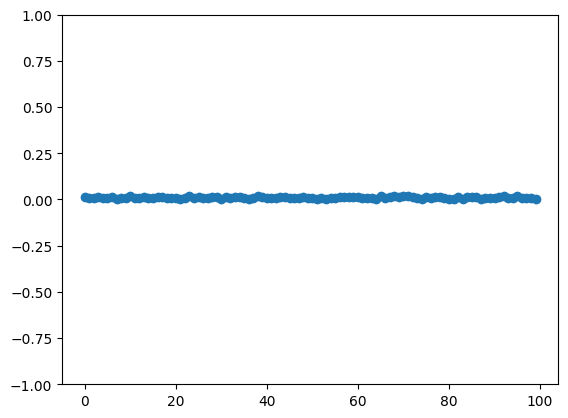

In [13]:
def select_individuals_to_mate():
    global last_individual_index
    
    population_fitness_scores = population[:last_individual_index + 1, 16].astype(np.float64)
    probabilities = population_fitness_scores * -1 + np.max(population_fitness_scores) + 1
    probabilities /= np.sum(probabilities)
    plt.ylim(-1,1)
    plt.scatter(x=list(range(len(population_fitness_scores))), y=probabilities)

    #return population[np.random.choice(population[:last_individual_index + 1].shape[0], size=2, p=probabilities, replace=False)]
select_individuals_to_mate()

In [ ]:
def pmx_crossover(parent1, parent2):
    child1 = np.array(np.zeros(15, dtype=np.float16), dtype=np.float16)
    child2 = np.array(np.zeros(15, dtype=np.float16), dtype=np.float16)
    
    b = np.array(list(range(2,13)))
    np.random.shuffle(b)
    slice_point1,slice_point2 = np.sort(b)[:2]
    
    child1[slice_point1:slice_point2] = parent2[slice_point1:slice_point2]
    child2[slice_point1:slice_point2] = parent1[slice_point1:slice_point2]
    
    # fill child1's remaining genes with parent1
    for i in range(15):
        if child1[i] != 0: continue
        
        value_to_fill = parent1[i]
        
        while value_to_fill in child1:
            value_to_fill = child2[np.where(child1 == value_to_fill)[0][0]]
            
        child1[i] = value_to_fill
    
    # fill child1's remaining genes with parent1
    for i in range(15):
        if child2[i] != 0: continue
        
        value_to_fill = parent2[i]
        
        while value_to_fill in child2:
            value_to_fill = child1[np.where(child2 == value_to_fill)[0][0]]
            
        child2[i] = value_to_fill
    
    # mutate the children with a possibility
    if random.random() < mutation_possibility:
        rpl = np.array(list(range(15)))
        np.random.shuffle(rpl)
        rp1, rp2 = rpl[:2]
        child1[rp1], child1[rp2] = child1[rp2], child1[rp1]
    
    if random.random() < mutation_possibility:
        rpl = np.array(list(range(15)))
        np.random.shuffle(rpl)
        rp1, rp2 = rpl[:2]
        child2[rp1], child2[rp2] = child2[rp2], child2[rp1]
    
    return child1, child2

In [ ]:
# start the evolution
started_evolution_at = datetime.datetime.now()
for _ in range(100): make_individual(chromosome=random_chromosome())
try:
    while True:
        for _ in range(50): # make 100 children.
            individuals_to_mate = select_individuals_to_mate()
            child1_chromosome, child2_chromosome = pmx_crossover(individuals_to_mate[0][:15], individuals_to_mate[1][:15])
            make_individual(chromosome=child1_chromosome)
            make_individual(chromosome=child2_chromosome)
            
        if last_individual_index - best_individuals_index > 400 and mutation_possibility < 0.4:
            mutation_possibility += 0.1

except KeyboardInterrupt: print('finished.')

In [ ]:
last_individual_index

In [ ]:
population[:last_individual_index + 1, 16]